In [151]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

In [152]:
# Function to load IMDB data
def load_imdb_data(data_file):
    df = pd.read_csv(data_file)
    # df = df.sample(frac=0.01, random_state=42)
    texts = df['review'].tolist()
    labels = [1 if sentiment == "positive" else 0 for sentiment in df['sentiment'].tolist()]
    return texts, labels

# Dataset class for sentiment analysis
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Function to train the model 
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=1):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}")
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        val_loss = evaluate_model(model, val_loader, criterion, device)
        print(f"Epoch {epoch + 1}, Avg Loss: {epoch_loss / len(train_loader)}, Val Loss: {val_loss}")

# Function to evaluate the model
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)
            val_loss += loss.item()

    return val_loss / len(val_loader)


data_file = "IMDB Dataset.csv"
texts, labels = load_imdb_data(data_file)

# Split the dataset into train, validation, and test sets (80% train, 10% validation, 10% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(test_texts, test_labels, test_size=0.333, random_state=42)

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Prepare datasets and dataloaders
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer, max_len=256)
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer, max_len=256)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer, max_len=256)

print(f"Train dataset size: {len(train_dataset)}", f"Val dataset size: {len(val_dataset)}", f"Test dataset size: {len(test_dataset)}", sep='\n')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Train the model
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=1)


c:\Users\gavin\.conda\envs\nlp\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`.

Train dataset size: 35000
Val dataset size: 10005
Test dataset size: 4995


Epoch 1/1: 100%|██████████| 2188/2188 [47:16<00:00,  1.30s/it, loss=0.0513] 


Epoch 1, Avg Loss: 0.24726287329397495, Val Loss: 0.2188113516824433


In [153]:
#save the model
torch.save(model.state_dict(), 'model.pth')

In [154]:
print(len(test_loader))

313


In [155]:
# Function to evaluate the model on test set with tqdm progress bar
def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Testing")
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1

# Example usage
test_model(model, test_loader, device)


Testing: 100%|██████████| 313/313 [00:55<00:00,  5.67it/s]

Test Accuracy: 0.9191
Precision: 0.9286
Recall: 0.9085
F1 Score: 0.9184


(0.9191191191191191,
 0.9285714285714286,
 0.9085463258785943,
 0.9184497375857893)

In [156]:
def visualize_lastlayer_attention(model, tokenizer, text, device):
    model.eval()  # Set model to evaluation mode

    # Tokenize the input text and get tokens
    inputs = tokenizer(text, return_tensors='pt', add_special_tokens=True, truncation=True, max_length=64).to(device)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())  # Get token list
    
    # Forward pass to get attention weights
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Access attention weights
    attention_weights = outputs.attentions  # List of attention matrices from each layer
    # print(f"Number of layers: {attention_weights}")
    last_layer_attention = attention_weights[-1]  # Get attention from the last layer
    attention_matrix = last_layer_attention[0].detach().cpu().numpy()  # Shape: (batch_size, num_heads, seq_len, seq_len)

    # Plotting the heatmap for the first attention head (attention_matrix[0])
    fig, ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(attention_matrix[0], cmap="viridis", xticklabels=tokens, yticklabels=tokens, ax=ax, vmin=0, vmax=1)
    
    # Title and labels
    ax.set_title(f"Attention Heatmap for: '{text}'", fontsize=16)
    ax.set_xlabel("Token Attention", fontsize=12)
    ax.set_ylabel("Tokens", fontsize=12)
    
    plt.xticks(rotation=90)  # Rotate x-axis token labels for readability
    plt.show()
def predict_sentiment(model, tokenizer, sentence, device):
    model.eval()  # Set the model to evaluation mode
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=64, padding='max_length').to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    sentiment = "Positive" if predicted_class == 1 else "Negative"
    
    print(f"Predicted sentiment for \"{sentence}\": {sentiment}")
    return sentiment
def visual_multi_layer(model, tokenizer, text, device):
    model.eval()  # Set model to evaluation mode

    # Tokenize the input text and get tokens
    inputs = tokenizer(text, return_tensors='pt', add_special_tokens=True, truncation=True, max_length=64).to(device)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())  # Get token list
    
    # Forward pass to get attention weights
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Access attention weights
    attention_weights = outputs.attentions  # List of attention matrices from each layer
    print(f"Number of layers: {len(attention_weights)}")
   
    # Plotting the heatmap for the first attention head (attention_matrix[0])
    fig, ax = plt.subplots(4, 3, figsize=(24, 24))
    for i in range(12):
        attention_matrix = attention_weights[i][0].detach().cpu().numpy()
        sns.heatmap(attention_matrix[0], cmap="viridis", xticklabels=tokens, yticklabels=tokens, ax=ax[i//3, i%3], vmin=0, vmax=1)
        ax[i//3, i%3].set_title(f"Layer {i+1}")
        ax[i//3, i%3].set_xlabel("Token Attention")
        ax[i//3, i%3].set_ylabel("Tokens")
        ax[i//3, i%3].set_xticks([])
        ax[i//3, i%3].set_yticks([])
    
    plt.show()
def visual_average_attention(model, tokenizer, text, device):
    model.eval()  # Set model to evaluation mode

    # Tokenize the input text and get tokens
    inputs = tokenizer(text, return_tensors='pt', add_special_tokens=True, truncation=True, max_length=64).to(device)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())  # Get token list
    
    # Forward pass to get attention weights
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Access attention weights
    attention_weights = outputs.attentions
    text_length = len(tokens)
    attention_matrix = np.zeros((12, text_length, text_length))
    for i in range(12):
        attention_matrix += attention_weights[i][0].detach().cpu().numpy()
    attention_matrix /= 12
    print(attention_matrix.shape)
    attention_weights = attention_matrix
    

    # Plotting the heatmap for the first attention head (attention_matrix[0])
    fig, ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(attention_weights[0], cmap="viridis", xticklabels=tokens, yticklabels=tokens, ax=ax, vmin=0, vmax=1)
    
    # Title and labels
    ax.set_title(f"Average Attention Heatmap for: '{text}'", fontsize=16)
    ax.set_xlabel("Token Attention", fontsize=12)
    ax.set_ylabel("Tokens", fontsize=12)
    
    plt.xticks(rotation=90)  # Rotate x-axis token labels for readability
    plt.show()

In [157]:
test_sentence = "This was the worst movie I saw at WorldFest"

### All layer heatmap

Predicted sentiment for "This was the worst movie I saw at WorldFest": Negative
Number of layers: 12


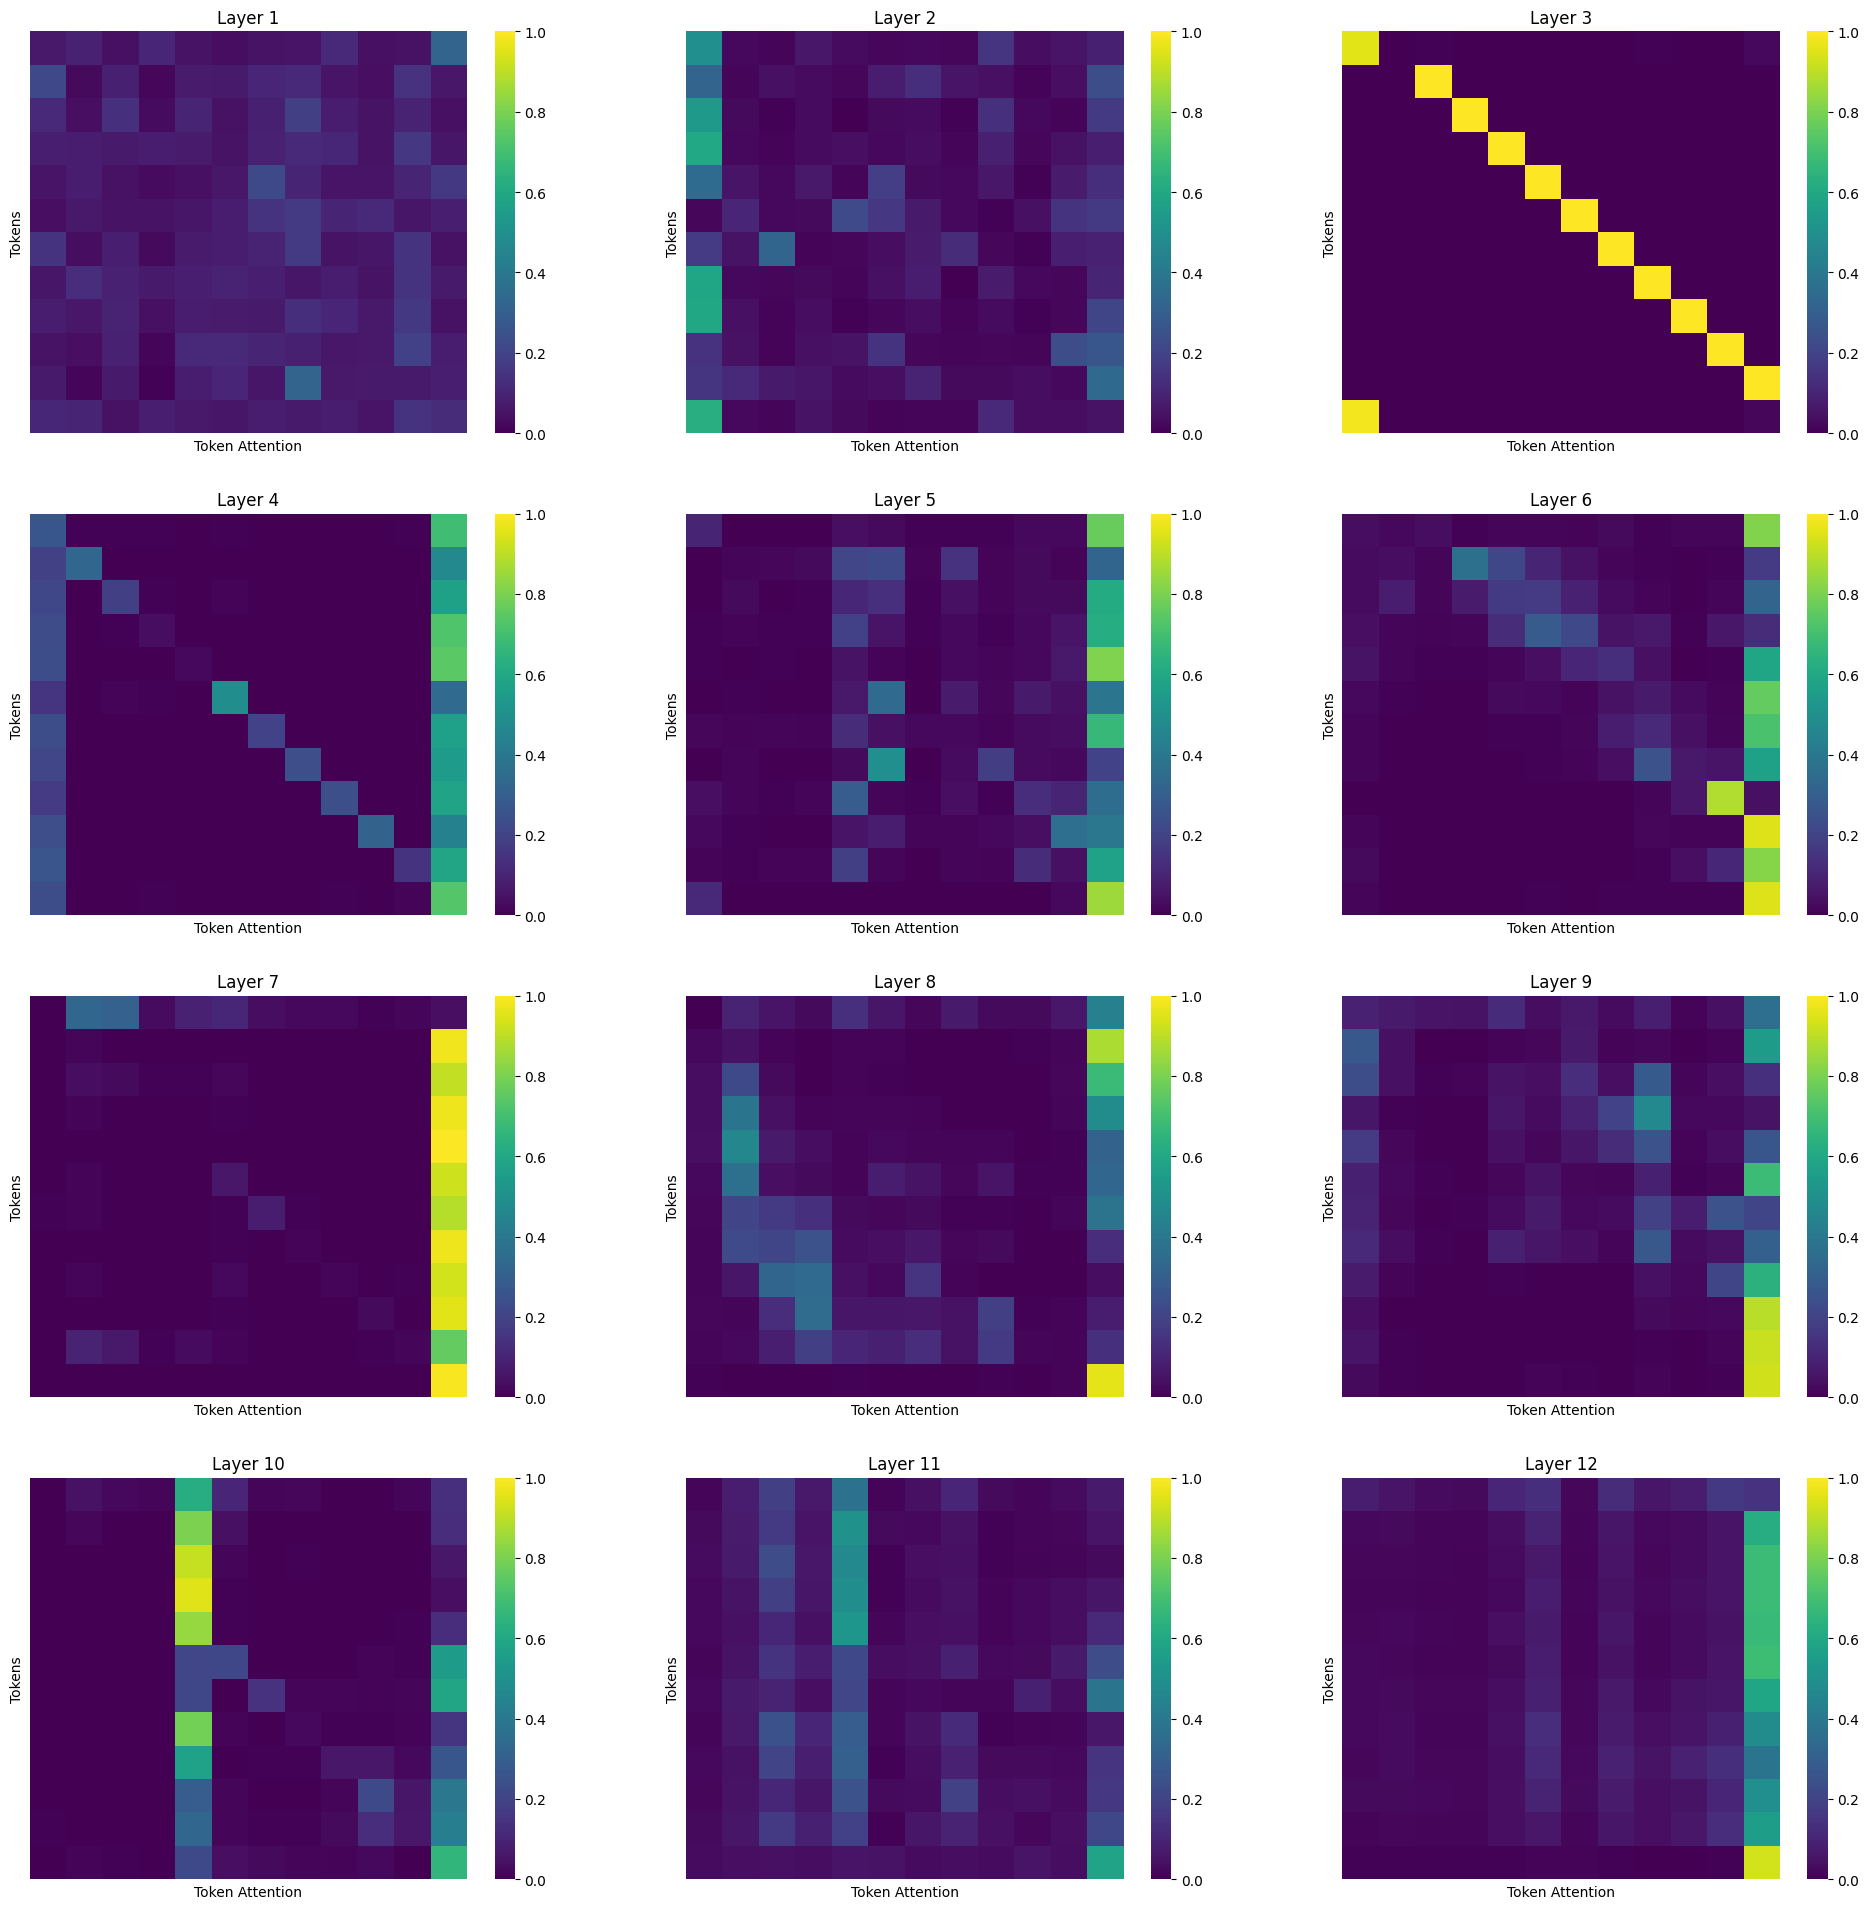

In [158]:

predict_sentiment(model, tokenizer, test_sentence, device)

# Visualize attention heatmap for the same sentence
visual_multi_layer(model, tokenizer, test_sentence, device)


### Average attention heatmap

(12, 12, 12)


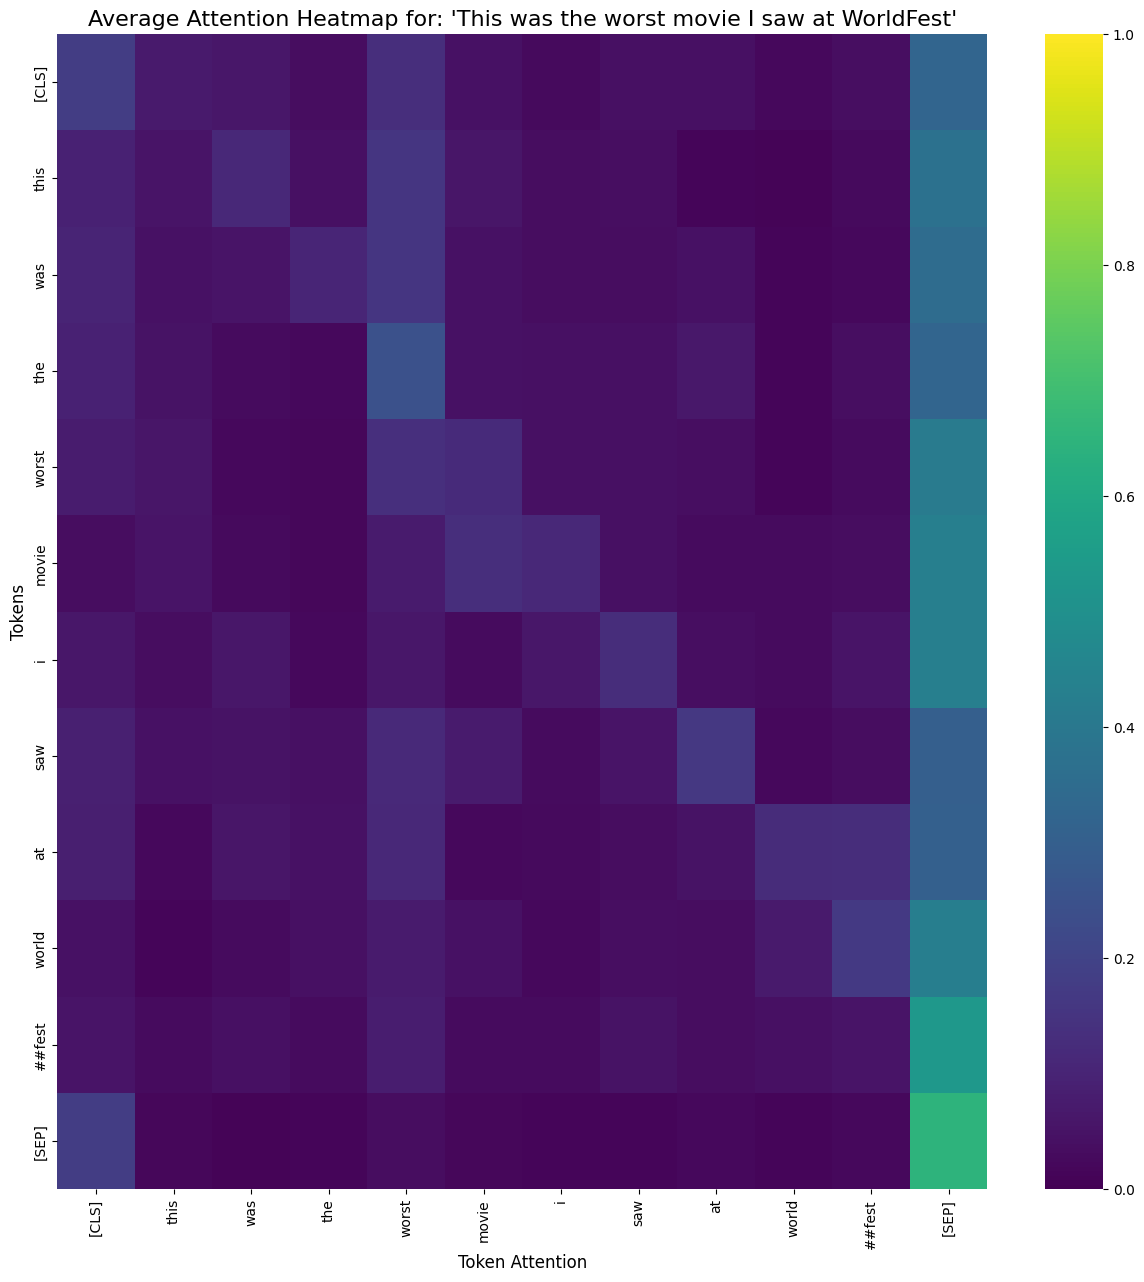

In [159]:
# Visualize average attention heatmap for the same sentence
visual_average_attention(model, tokenizer, test_sentence, device)


### Last layer attention heatmap

Predicted sentiment for "This was the worst movie I saw at WorldFest": Negative


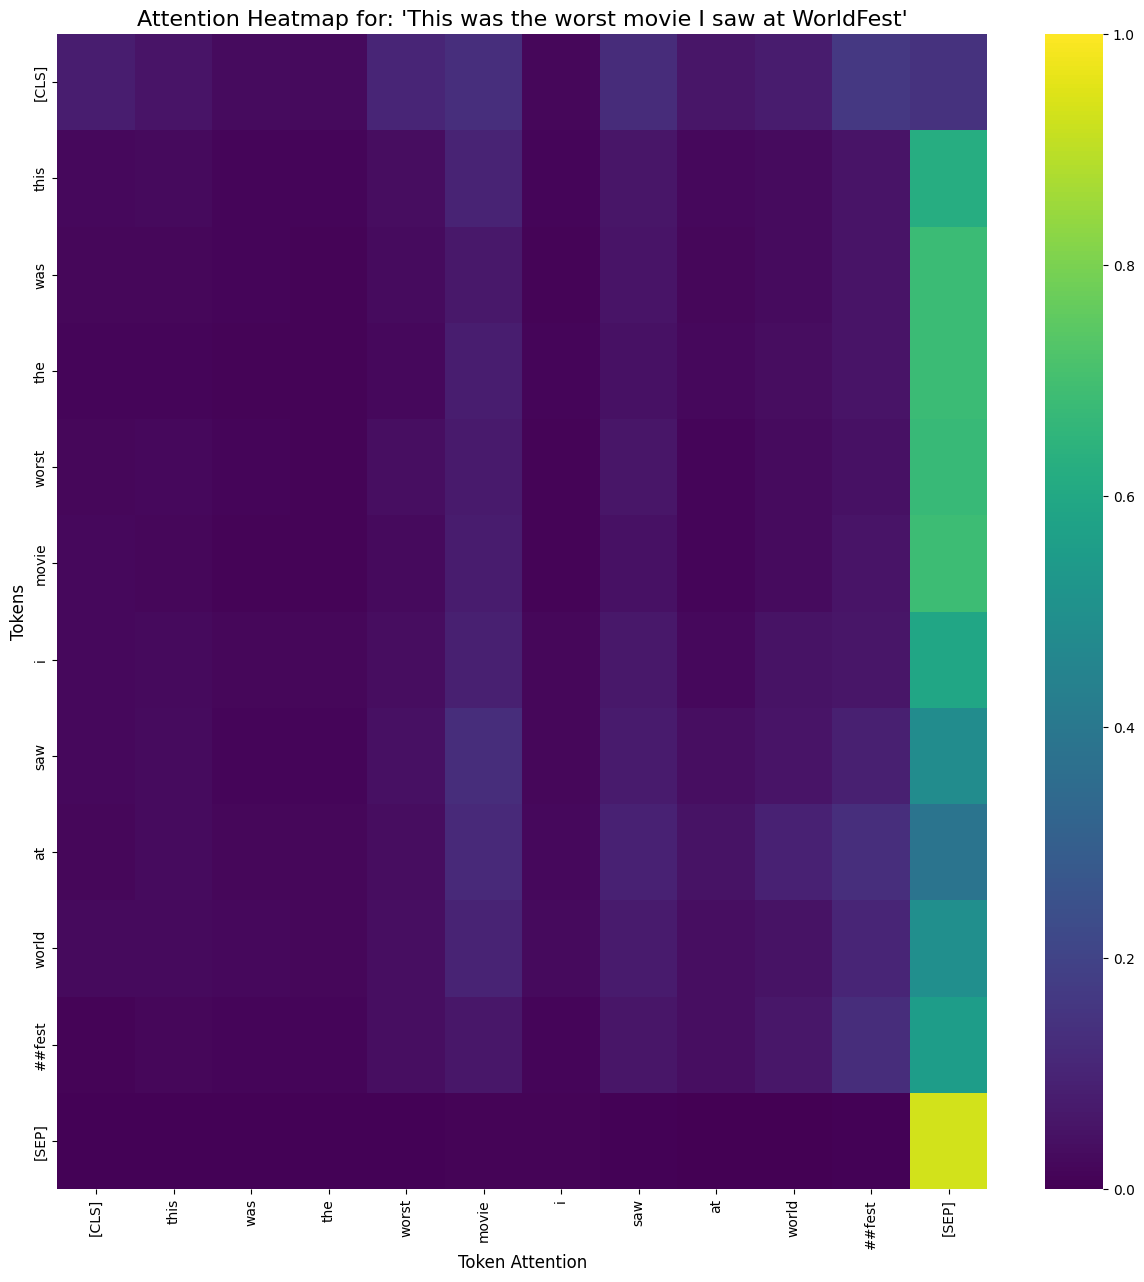

In [160]:

predict_sentiment(model, tokenizer, test_sentence, device)

# Visualize attention heatmap for the same sentence
visualize_lastlayer_attention(model, tokenizer, test_sentence, device)

In [161]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e